# Clustering with volcano seismic spectra

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [2]:
#load data

frequency = pd.read_csv('frequency.csv',header=None)
time = pd.read_csv('spectrogram_time.csv',header=None)
synthetic_spectrogram = pd.read_csv('synthetic_spectrogram.csv',header=None)
synthetic_spectrogram_norm = pd.read_csv('synthetic_spectrogram_norm.csv',header=None)

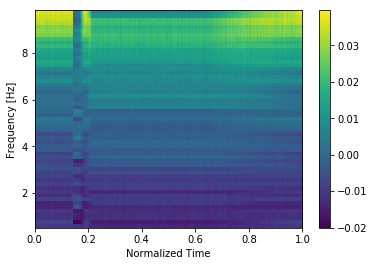

In [3]:
#visualize normalized data

extent = [0,1,frequency.min()[0],frequency.max()[0]]
plt.imshow(synthetic_spectrogram_norm.T,aspect='auto',extent = extent)
plt.colorbar()
plt.xlabel('Normalized Time')
plt.ylabel('Frequency [Hz]')
plt.show()

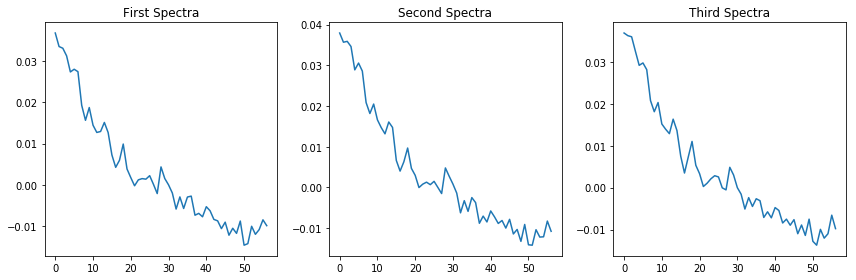

In [4]:
#plot first three spectra in the series

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.plot(synthetic_spectrogram_norm.iloc[0,:])
plt.title('First Spectra')

plt.subplot(132)
plt.plot(synthetic_spectrogram_norm.iloc[1,:])
plt.title('Second Spectra')

plt.subplot(133)
plt.plot(synthetic_spectrogram_norm.iloc[2,:])
plt.title('Third Spectra')

plt.tight_layout()
plt.show()

#note that they're quite similar!

# SOLUTIONS

### a) applying hierarchical clustering on the synthetic data

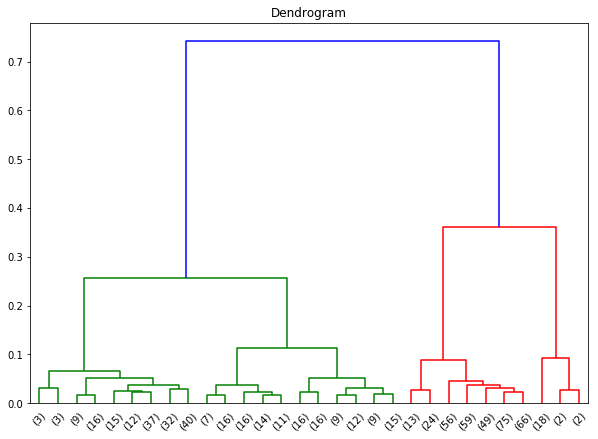

In [7]:
# used this blog post for code: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

data = np.copy(synthetic_spectrogram_norm)
linked = linkage(data,'ward')
labelList = range(1, len(frequency))

plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=30)
plt.title('Dendrogram')
plt.show()

In [8]:
#now cluster
n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)

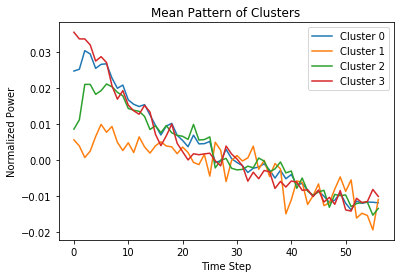

In [9]:
#visualize clusters

plt.plot(cluster_pattern.T)
plt.ylabel('Normalized Power')
plt.xlabel('Time Step')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.show()

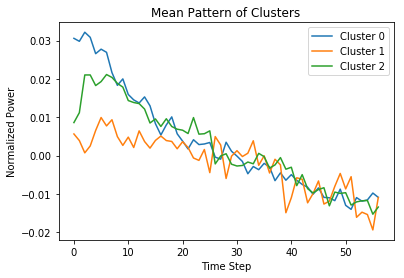

In [10]:
#change number of clusters and see how things change!
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
plt.plot(cluster_pattern.T)
plt.ylabel('Normalized Power')
plt.xlabel('Time Step')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.show()

### b) Apply PCA on the synthetic data

In [11]:
#do PCA using built-in library

n_modes = np.min(np.shape(synthetic_spectrogram_norm))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(synthetic_spectrogram_norm)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

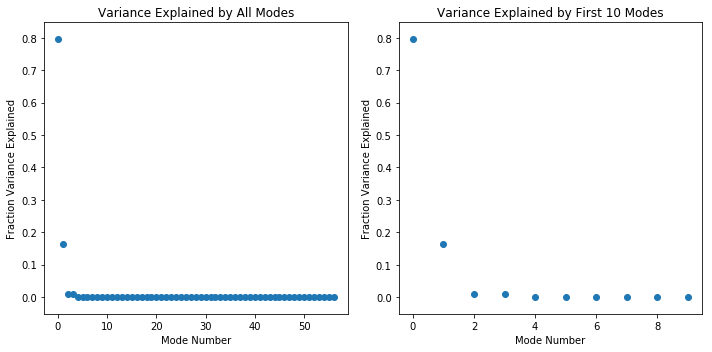

In [12]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

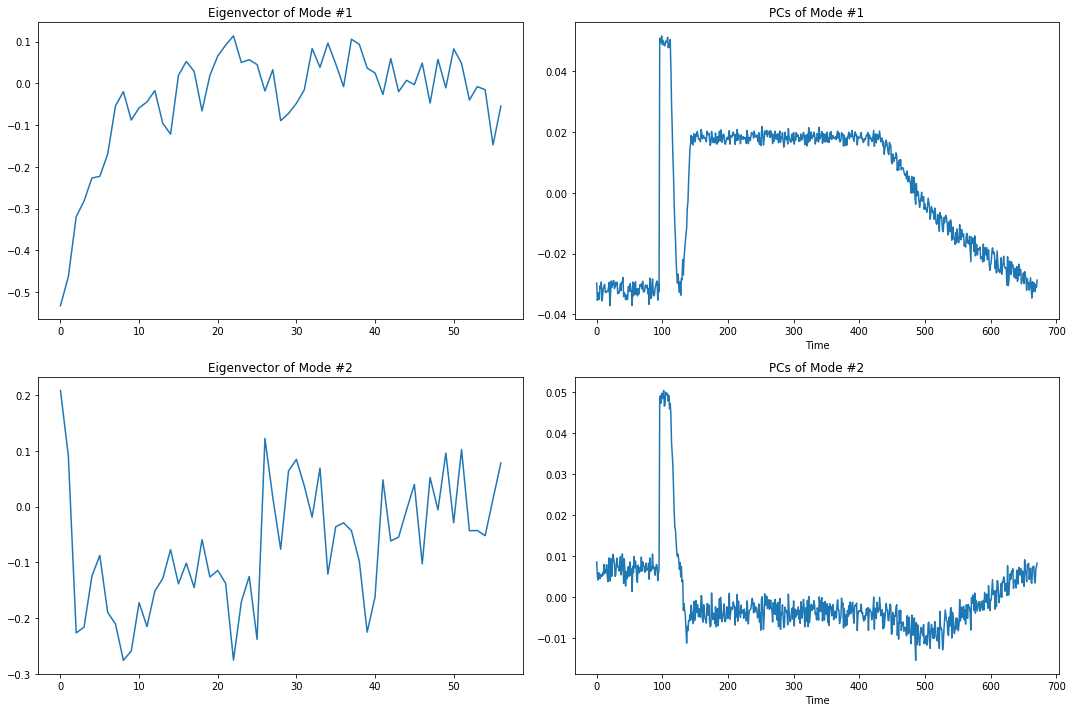

In [13]:
#plot the first n modes and PCs

n = 2 #looks like the first two modes explain pretty much everything!

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(eigvecs[kk,:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.tight_layout()

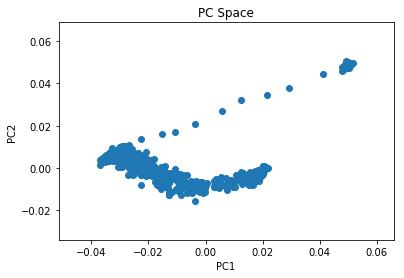

In [14]:
#plot PC-space -- can you see any clusters?

plt.scatter(PCs[:,0],PCs[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC Space')
plt.show()

### c) Apply hierarchical clustering on the data in the space of first few PCs 

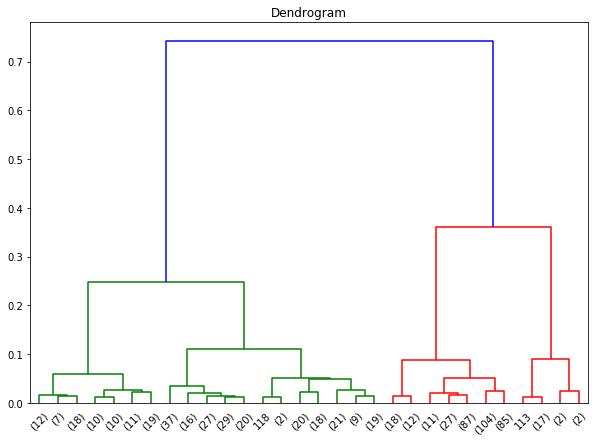

In [16]:
data = PCs[:,:2]
linked = linkage(data,'ward')
labelList = range(1, len(frequency))

plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=30)
plt.title('Dendrogram')
plt.show()

In [17]:
#now cluster
n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern_PC = np.empty((n_clusters,np.shape(data)[1]))
cluster_pattern = np.empty((n_clusters,np.shape(synthetic_spectrogram_norm)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern_PC[cluster_num,:] = np.mean(data[inds,:],axis=0)
    cluster_pattern[cluster_num,:] = np.mean(synthetic_spectrogram_norm.iloc[np.squeeze(inds),:],axis=0)

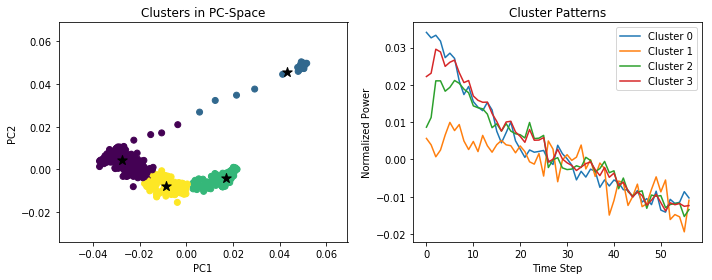

In [18]:
#visualize clusters in PC-space

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(PCs[:,0],PCs[:,1],c=cn)
plt.scatter(cluster_pattern_PC[:,0],cluster_pattern_PC[:,1],marker='*',c='k',s=100)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('Clusters in PC-Space')

plt.subplot(122)
plt.plot(cluster_pattern.T)
plt.xlabel('Time Step')
plt.ylabel('Normalized Power')
plt.title('Cluster Patterns')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])

plt.tight_layout()
plt.show()

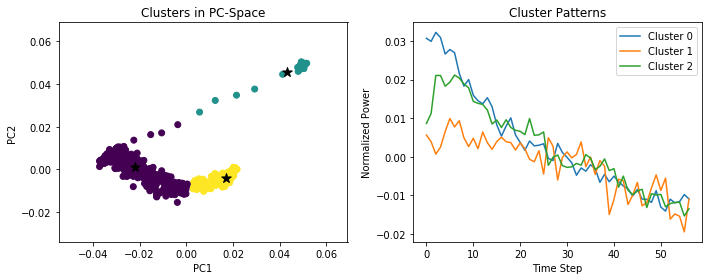

In [19]:
#now, how about a different number of clusters?
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern_PC = np.empty((n_clusters,np.shape(data)[1]))
cluster_pattern = np.empty((n_clusters,np.shape(synthetic_spectrogram_norm)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern_PC[cluster_num,:] = np.mean(data[inds,:],axis=0)
    cluster_pattern[cluster_num,:] = np.mean(synthetic_spectrogram_norm.iloc[np.squeeze(inds),:],axis=0)
    
#visualize clusters in PC-space
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(PCs[:,0],PCs[:,1],c=cn)
plt.scatter(cluster_pattern_PC[:,0],cluster_pattern_PC[:,1],marker='*',c='k',s=100)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('Clusters in PC-Space')

plt.subplot(122)
plt.plot(cluster_pattern.T)
plt.xlabel('Time Step')
plt.ylabel('Normalized Power')
plt.title('Cluster Patterns')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])

plt.tight_layout()
plt.show()